
### Project: Supervised learning algorithms for predicting article retweets and likes based on the title

In [43]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Import any additional functionality you may need here
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('whitegrid')
sns.set_palette('coolwarm')

import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download()
from nltk.corpus import stopwords

print('Success')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
Success


In [2]:
df_title = pd.read_json("dataset/dataset-tweets-final.json")

In [3]:
df_title.head(3)

,id,retweet_count,favorite_count,text,created_at,url,medium_claps,medium_categories
0,1026876138969333800,5,10,How to use JSON padding (and other options) to...,2018-08-07 17:02:04,https://medium.freecodecamp.org/use-jsonp-and-...,177,"[JavaScript, HTML, Web Development, Tutorial, ..."
1,1026831326425505800,7,19,How to build GitHub search functionality in Re...,2018-08-07 14:04:00,https://medium.freecodecamp.org/how-to-build-a...,61,"[React, Tech, Functional Programming, Programm..."
2,1026815727163064300,6,11,How to read and write Mindful Minutes from iOS...,2018-08-07 13:02:01,https://medium.freecodecamp.org/read-write-min...,54,"[iOS, Software Development, Programming, Web D..."


In [4]:
# Lets clean the data first.
# Many duplicates entries are present.
# Few columns are not required for further analysis.
# After observing the json file, It can be seen that many titles have non-ascii characters. 
# For an efficient analysis, we have to get rid of these mixed characters.

In [5]:
# Duplicate entries
df_title = df_title.drop_duplicates(subset=['text'], keep=False)

In [6]:
# Irrelevant columns
df_title = df_title.drop(['id', 'created_at', 'url'], axis=1)

In [7]:
# Formatting the title
df_title['text'] = df_title['text'].map(lambda x: re.sub(r'\\x[00-ff]{2}','',str(x)))
df_title['text'] = df_title['text'].str.strip()
df_title['text'] = df_title['text'].map(lambda x: re.sub('b"','',str(x)))

In [8]:
# calculating the length of title, whch will be used as an important feature for analysis
df_title['text_lenght'] = df_title['text'].str.len()

In [9]:
# current snapshot of dataframe 
df_title.head()

,retweet_count,favorite_count,text,medium_claps,medium_categories,text_lenght
0,5,10,How to use JSON padding (and other options) to...,177,"[JavaScript, HTML, Web Development, Tutorial, ...",76
1,7,19,How to build GitHub search functionality in Re...,61,"[React, Tech, Functional Programming, Programm...",90
2,6,11,How to read and write Mindful Minutes from iOS...,54,"[iOS, Software Development, Programming, Web D...",81
3,9,39,"How to make more money on Upwork, by @jpmorris",139,"[Freelancing, Tech, Web Development, Web Desig...",46
4,14,62,Let's build a fun little game: Learn advanced ...,342,"[CSS, Games, Tech, Programming, React]",116


In [10]:
# reorder the columns
df_title = df_title[df_title.columns[[4, 0, 3, 2, 5, 1]]]

In [11]:

# Rename the columns with more obvious names and making an copy of dataframe 
temp = df_title.rename(index=str, columns={"favorite_count": "Likes (Twitter)", "medium_categories": "Categories (Medium)", "medium_claps": "Claps (Medium)", "retweet_count": "Retweet (Twitter)", "text": "Title (Twitter)", "text_lenght": "Title Length"})
df_title = df_title.rename(index=str, columns={"favorite_count": "Likes", "medium_categories": "Categories", "medium_claps": "Claps", "retweet_count": "Retweet", "text": "Title", "text_lenght": "Title Length"})


### Exploratory Visualization

This section will explore the data visualization of the existing dataset and analyze the possible metrics that will be used to understand the solution. We will identify the relationship between each one of the features with the overall performance of the article. Within the following steps we will discuss:

* General statistic overview of the dataset
* Distribution of retweets, claps and favorites
* Relation of the title length with the performance of the article
* Relation of the article's categories with the performance of the article
* Relation of the article's words with the performance of the article
* Try to identify the relation between the features

#### Overall Statistics

We will analyze here the high-level statistics of the articles. Try to understand how many times the articles were on average retweeted, clapped or liked. Also, understand the average length and number of words of the title.

In [12]:
# calculate length of the titles
df_title['Title Length'] = df_title['Title'].str.len()
df_title.describe()

,Retweet,Claps,Title Length,Likes
count,711.000000,711.000000,711.000000,711.000000
mean,16.438819,285.263010,77.136428,49.291139
std,15.685065,273.451934,20.213779,45.234113
min,0.000000,1.000000,21.000000,0.000000
25%,6.500000,7.500000,62.000000,20.000000
50%,11.000000,238.000000,76.000000,34.000000
75%,20.000000,471.500000,93.000000,63.500000
max,125.000000,997.000000,117.000000,298.000000


In [13]:
df_title.head(3)

,Categories,Retweet,Claps,Title,Title Length,Likes
0,"[JavaScript, HTML, Web Development, Tutorial, ...",5,177,How to use JSON padding (and other options) to...,76,10
1,"[React, Tech, Functional Programming, Programm...",7,61,How to build GitHub search functionality in Re...,90,19
2,"[iOS, Software Development, Programming, Web D...",6,54,How to read and write Mindful Minutes from iOS...,81,11


In [14]:
df_title[df_title.Retweet==125]

,Categories,Retweet,Claps,Title,Title Length,Likes
710,"[Self Improvement, Startup, Productivity, Educ...",125,18,RT @ossia: The unlikely history of the #100Day...,99,0


In [15]:
df_title[df_title.Claps==997]

,Categories,Retweet,Claps,Title,Title Length,Likes
545,"[AWS, Tech, Life Lessons, Self Improvement, So...",13,997,Why Im automatically deleting all my old tweet...,109,49


From this statistic is possible to understand the order of magnitude of our dataset. Articles normally are retweeted and likes around tens of times and clapped hundreds of times. It is possible to check the maximum values from all the three variables, retweet and like hundreds and clap thousand of times. From these numbers, we can define what is expected from our articles and the interaction with them. The length of the text goes from 21 to 117 characters, as expected, for a tweet content.

#### Histogram and Box plots

In this section we will check how the multiple features are distributed.

Total Retweets: 11688 times


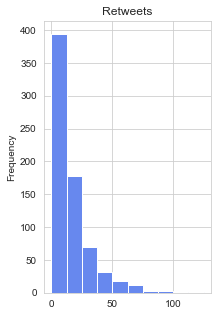

In [16]:
plt.figure(figsize=(3, 5))
df_title.Retweet.plot.hist(title = 'Retweets')
n_r = df_title.Retweet.sum()
print('Total Retweets: {} times'.format(n_r))
plt.show()

Total Likes: 35046 times


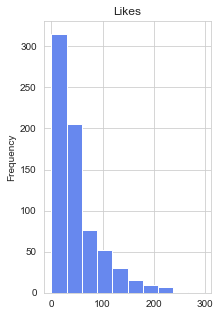

In [17]:
plt.figure(figsize=(3, 5))
df_title.Likes.plot.hist(title = 'Likes')
n_l = df_title.Likes.sum()
print('Total Likes: {} times'.format(n_l))
plt.show()

Total Claps: 202822 times


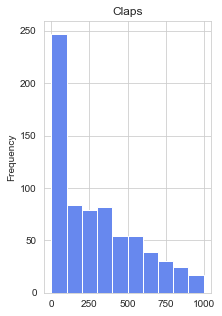

In [18]:
plt.figure(figsize=(3, 5))
df_title.Claps.plot.hist(title = 'Claps')
n_c = df_title.Claps.sum()
print('Total Claps: {} times'.format(n_c))
plt.show()

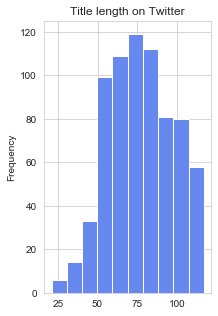

In [19]:
plt.figure(figsize=(3, 5))
df_title['Title Length'].plot.hist(title = 'Title length on Twitter')
plt.show()

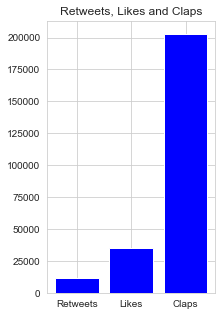

In [20]:
# Plot between number of Retweets, Likes and Claps

plt.figure(figsize=(3, 5))
d = {'Retweets': n_r, 'Likes':n_l, 'Claps':n_c}
plt.bar(list(d.keys()), list(d.values()), color='blue' )
plt.title('Retweets, Likes and Claps')
plt.show()

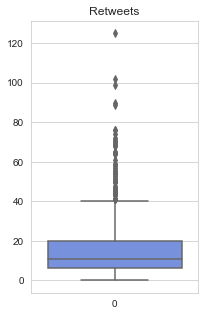

In [21]:
plt.figure(figsize=(3, 5))
plt.title('Retweets');
sns.boxplot(data=df_title.Retweet);
plt.show()

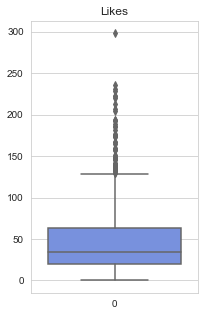

In [22]:
plt.figure(figsize=(3, 5))
plt.title('Likes');
sns.boxplot(data=df_title.Likes);
plt.show()

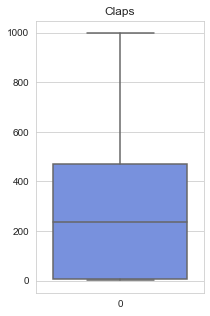

In [23]:
plt.figure(figsize=(3, 5))
plt.title('Claps');
sns.boxplot(data=df_title.Claps);
plt.show()

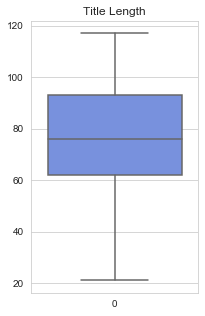

In [24]:
plt.figure(figsize=(3, 5))
plt.title('Title Length');
sns.boxplot(data=df_title['Title Length']);
plt.show()

Insights from the above analysis:
- Title length has a Normal Distribution
- Average length is around 80 characters
- Like, retweet and claps are positive-skewed, i.e. they are concentrated on the left part of the graph
- positive skewness shows that small part of the articles will over-perform about readers' interaction and the biggest part of them will generate less interaction.

#### Scatter Matrix

Scatter Matrix is one of the best way to find the relationship between all avaialable feature.
Ideally diagonal graph should be like a straight line. but to keep it more informative,diagonal = 'kde' is used which shows the sensity of the feature.

Insights from the Scatter Matrix:

- There is a strong corelation between 'Number of Retweets' and 'Number of likes' 
- Rest of the features are not showing a direct corealtion, need to be analysed further.


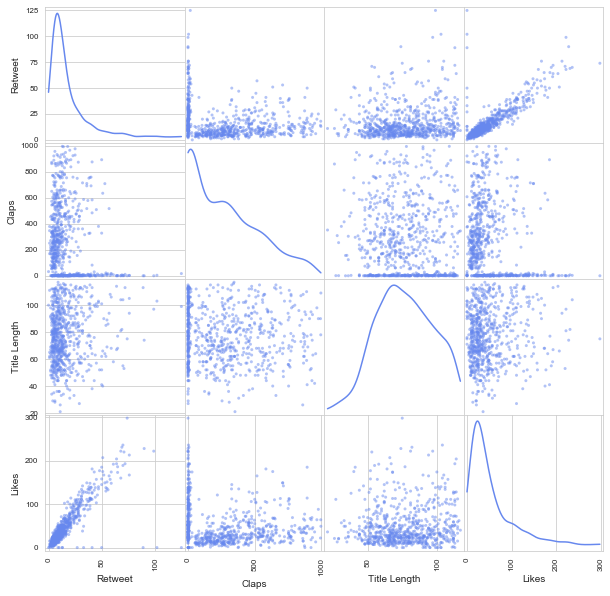

In [25]:
temp = pd.plotting.scatter_matrix(df_title, diagonal="kde", figsize=(10, 10))

Because we didn't get any specific insight from the scatter matrix results, we need to explore other features. 
We are going to find if there is any relationship between popularity of title vs length of words used in the title.


In [26]:
# remove the outlier data ponts. We use the forumla:
# Outlier < Q_1 - 1.5* IQR
# Outlier > Q_3 + 1.5 * IQR
# Where Q_1 and Q_3 are the first and third quartile
# and IQR is the Interquartile Range (IQR = Q_3 - Q_1).
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    non_outliers = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)
#     non_outliers = df[column] >= 0
    return df.loc[non_outliers]

In [27]:
# for reuse in various functions
title_length = 'Title Length'
columns = [{'column_name': 'Retweet', 'column_text': 'Retweets'},
           {'column_name': 'Likes', 'column_text': 'Likes on Twitter'},
           {'column_name': 'Claps', 'column_text': 'Claps on Medium'},
           {'column_name': 'Title Length', 'column_text': 'Title length on Twitter'}] 

In [28]:
# plot relation between the number of retweet/favorite/claps and the title length or words in title

def plot_top_length_performers(col_name, is_grouped):
    plt.figure(figsize=(10, 5))      
    for el in columns:
        class_name = el['column_name']
        column = df_title[class_name]
        if class_name != title_length:
            plt.subplot(1, 3, columns.index(el) + 1)
            plt.tight_layout()
            # remove outliers
            df_title_top = remove_outliers(df_title, class_name)
            if (is_grouped):
                temp = df_title_top.groupby(pd.cut(df_title_top[col_name], bins=np.arange(0, 140+10, step=10))).count()[class_name]
            else:
                temp = df_title_top.groupby(df_title_top[col_name]).count()[class_name]
            temp.plot.bar()
            #sns.despine()
            plt.title('{} frequency'.format(el['column_name']));

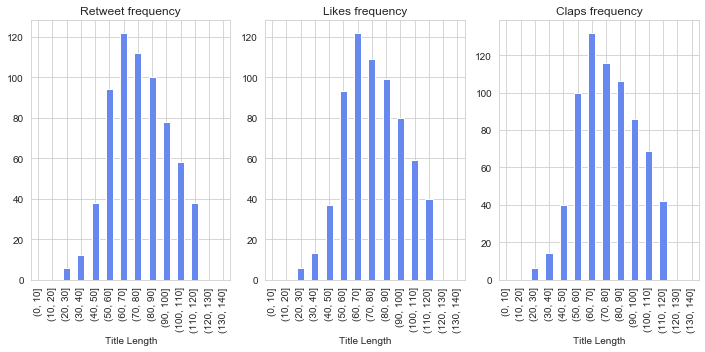

In [29]:
plot_top_length_performers('Title Length', True)

Insights from the above analysis:

- Title length vvaries betwee 50 to 110 for higher retweets
- Title length varies between 50 to 110 for higher likes
- Title length varies between 50 to 110 for higher Claps

- All over conclusion from the above plots is that on average title length ranges from 50 to 110 leds to more poplar
  article on social media. 

#### Number of words in the title that performed better

From this second experience showed on image bellow, we reached the conclusion that the best number of words in the title is from 9 to 17 words. To optimize the number of retweets and likes something from 9 to 18, and for claps from 7 to 17 words.

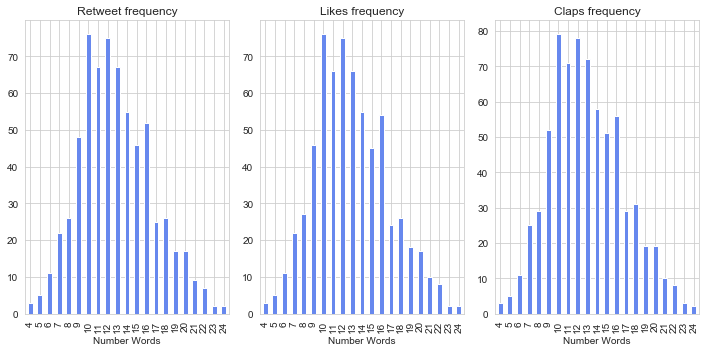

In [30]:
# plot relation between the number of retweet/favorite/claps and the number of words title length or words in title

number_words = 'Number Words'
df_title[number_words] = df_title['Title'].str.split().apply(len)
plot_top_length_performers(number_words, False)

#### Categories that performed better



In [31]:
# plot relation between the words used on medium title and the number of retweet/favorite/claps. Just for the top PERCENTAGE% performers
def plot_top_performers(lst_col):
    for el in columns:
        column = df_title[el['column_name']]
        class_name = el['column_name']
        if class_name != title_length:
            plt.figure(figsize=(10, 5))
            # remove outliers
            df_title_top = remove_outliers(df_title, class_name)
          
            x = pd.DataFrame({
                    col:np.repeat(df_title_top[col].values, df_title_top[lst_col].str.len())
                    for col in df_title_top.columns.difference([lst_col])
                }).assign(**{lst_col:np.concatenate(df_title_top[lst_col].values)})[df_title_top.columns.tolist()]
            temp = x.groupby(lst_col).count()[class_name].sort_values(ascending=False).head(20).sort_values(ascending=True)
            temp.plot.barh()
            #sns.despine()
            plt.title('Most used {} on {}'.format(lst_col, el['column_text']));

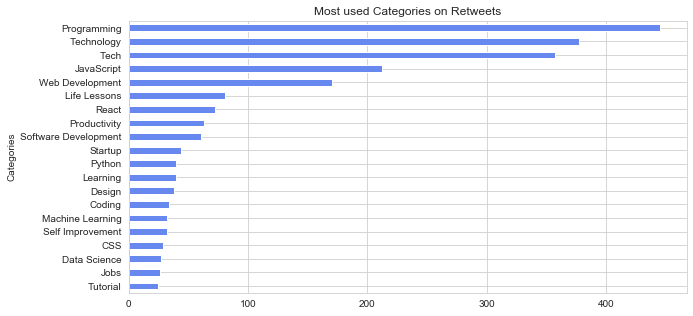

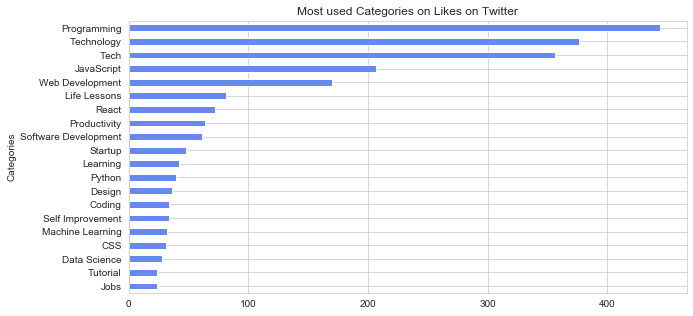

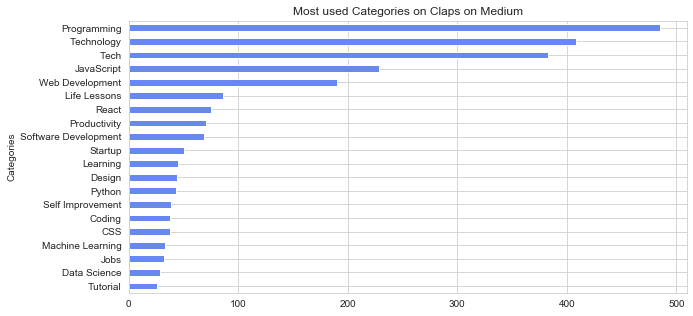

In [32]:
# plot relation between the tag used on medium (tag) and the number of retweet/favorite/claps
plot_top_performers('Categories')

From the above graphs we can observ that following catagories can be concluded as a part of scoical media hit article :

- Programming
- Technology
- Tec
- Javascript 
- Web Development



#### Words that performed better


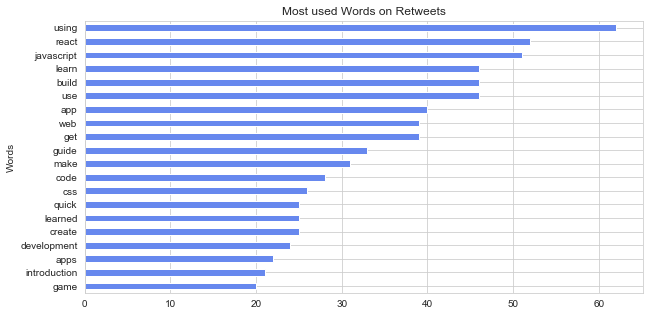

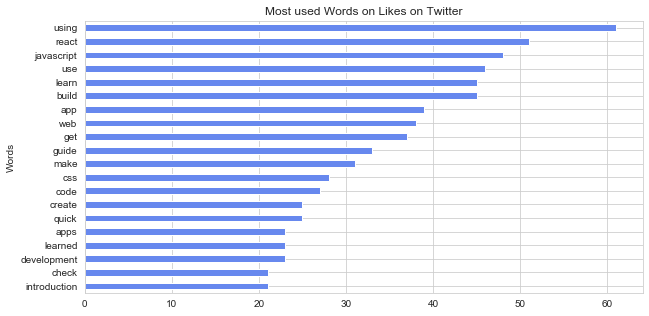

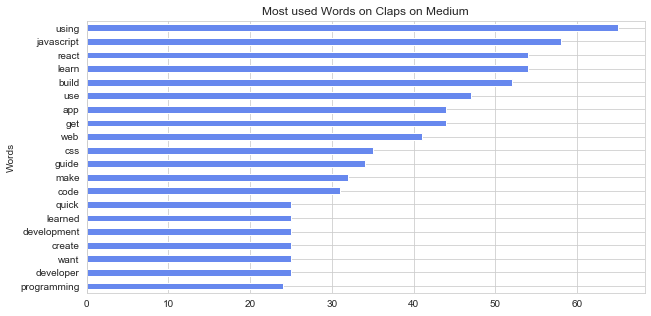

In [33]:
# create a column containing the words of the title

# remove special characters
temp = df_title['Title'].str.lower().str.translate(str.maketrans('','','()!@#$:"?,./+')).str.split()

# remove common words (it, a, the, ...)
stop=set(stopwords.words('english'))
df_title['Words'] = temp.apply(lambda x: [item for item in x if item not in stop and not '\\' in item])


# plot relation between the words used on medium title and the number of retweet/favorite/claps
#sns.despine()
plot_top_performers('Words')

This kind of analysis is alos called 'Token Analysis' or 'Lexical Analysis'.
Here title is separated by their respective wors. 
Commom words like in. at, for, the ,a ,an etc have been removed by using 'Stopword' imported from nltk library

Above analysis shows that there are few words like 
- using
- learn 
- app
- get
which can be included in the title to get more hits. 

Clearly this probelm can be solved by using supervised machine learning technique. There are several algorithms based on supervised learning . Following will be used to evaluate the perofrmace that which one is more efficent:

- SVM
- Decision Tree
- KNN
- Logistic Regression
- Naive Bayes classifier for multinomial models (MultinomialNB)


##### Assigning classes to the dataset

For this project, we decided to classify the number of retweets and likes in ranges. We wanted to make use of the properties of the Classification family of the Supervised Learning algorithms.

To avoid the Class Imbalance Problem, we divided the dataset into similar groups, as shown in image bellow.

In [34]:
def get_category_name(column_name):
    return '{} Category'.format(column_name)

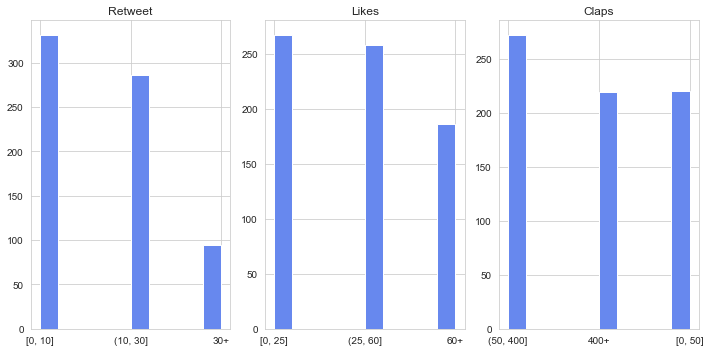

In [35]:
def get_range(value, ranges):
    for idx,max_value in enumerate(ranges):
        if value <= max_value:
            previous = '({}'.format(ranges[idx-1]) if idx >= 1 else '[0'
            return '{}, {}]'.format(previous, max_value)
    return '{}+'.format(ranges[-1])

# plot histogram of columns
plt.figure(figsize=(10, 5))
for el in columns:
    class_name = el['column_name']
    if class_name != title_length:
        column = df_title[class_name]
        plt.subplot(1, 3, columns.index(el) + 1)
        plt.tight_layout()
        ranges = {
            'Retweet': [10, 30],
            'Likes': [25, 60],
            'Claps': [50, 400]
        }
        column = [ get_range(a, ranges[class_name]) for a in column ]
        plt.title('{}'.format(class_name))
        pd.DataFrame(column)[0].hist(xrot=0)
        
        # add classification to dataframe
        df_title[get_category_name(class_name)] = column

### Bag of words

To be possible to analyze the title in each data point, we need to map each word into a number. This is necessary because machine learning models normally don't process raw text, but numerical values. To reach this, we used a bag of words model [11]. In this model, it is taken into consideration the presence and often the frequency of words, but the order or position is ignored.

For the calculation of the bag of words, we will use a measure called Term Frequency, Inverse Document Frequency (TF-IDF) [12]. The goal is to limit the impact of tokens (words) that occur very frequently.

At this step, we processed the collection of documents and built a vocabulary with the known words. We reached a vocabulary of 1356 words for retweets, 1399 words for likes and 1430 words for claps.



### Training and Testing Data Split





In [36]:
# clean the title
# removing twitter user name 
# keeping '@' symbol for further analysis
def clean_title(text):
    
    text = text.map(lambda x: re.sub('@[_A-Za-z0-9]+','@',str(x)))
    return text


def split_data(df_title, class_name, is_remove_outlier, is_clean_text):
            # remove outliers
            if is_remove_outlier:
                df_title_top = remove_outliers(df_title, class_name)
            else:
                df_title_top = df_title
                
            # Set the number of testing points
            if is_clean_text:
                X_all = clean_title(df_title_top['Title'])
            else:
                X_all = df_title_top['Title']
            y_all = df_title_top[get_category_name(class_name)]

            # Shuffle and split the dataset into the number of training and testing points above
            X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=ratios[class_name], shuffle=False)
        
            return {
                'df_title_top': df_title_top,
                'X_all': X_all,
                'y_all': y_all,
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }

In [37]:
X_all = {}
y_all = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}

ratios = {
    'Retweet': 0.2,
    'Likes': 0.2,
    'Claps': 0.2
}

for el in columns:
    column = df_title[el['column_name']]
    class_name = el['column_name']
    if class_name != title_length:
        values = split_data(df_title, class_name, True, True)
        df_title_top, X_all[class_name], y_all[class_name], X_train[class_name], X_test[class_name], y_train[class_name], y_test[class_name] = [values[k] for k in ('df_title_top', 'X_all','y_all', 'X_train', 'X_test', 'y_train', 'y_test')]
        
        total = df_title[class_name].count()
        total_no_outliers = df_title_top[class_name].count()
        print('{}\nTotal: {} items.\nTotal without outliers: {}'.format(class_name, total, total_no_outliers))
        
        # Show the results of the split
        print("Training set has {} samples".format(X_train[class_name].shape[0]))
        print("Testing set has {} samples\n".format(X_test[class_name].shape[0]))

Retweet
Total: 711 items.
Total without outliers: 658
Training set has 526 samples
Testing set has 132 samples

Likes
Total: 711 items.
Total without outliers: 658
Training set has 526 samples
Testing set has 132 samples

Claps
Total: 711 items.
Total without outliers: 711
Training set has 568 samples
Testing set has 143 samples



### Model Performance Metrics

Dataset is separated  into learning and validation set. 
A validation set is important to reduce the risk of over-fitting. 
To avoid discarding relevant data points,cross-validation has been used.

Cross-validation splits the training dataset in k folds, being k - 1 folders used to train the model and the last one to test it. This strategy will repeat multiple times and the overall performance is the average of the computed values.

To estimate the model's accuracy, we used a 5-fold cross validation that split the dataset into 5 parts, 4 of training and 1 of testing.

In [38]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import FunctionTransformer

# implement bag of words with td-idf
X_train_word_features = {}
test_features = {}

def get_text_length(x):
    return np.array([len(t) for t in x]).reshape(-1, 1)

def get_words_length(x):
    return np.array([len(t.split()) for t in x]).reshape(-1, 1)

def to_array(x):
    return x.toarray()

In [39]:

classifiers = [
    # no parameter to test for the model GaussianNB()
    {
        'classifier': GaussianNB(),
        'toarray': True,
        'parameters': {}
    },
    {
        'classifier': LogisticRegression(),
        'toarray': False,
        'parameters': {
            'C': [0.1, 0.5, 1, 2, 10],
            'fit_intercept': [True, False],
            'class_weight': ['balanced', None],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
            'max_iter': [10, 100, 300]
        }
    },
    {
        'classifier': DecisionTreeClassifier(),
        'toarray': False,
        'parameters': {
            'splitter': ['random', 'best'],
            'max_depth': [1, 5, 10, 20, None],
            'class_weight': ['balanced', None]
        }
    },
    {
        'classifier': SVC(),
        'toarray': True,
        'parameters': {
            'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
            'degree':[1, 2, 3, 4, 5, 6, 7],
            'C':[0.5, 1, 2],
        }
    },
    {
        'classifier': KNeighborsClassifier(),
        'toarray': False,
        'parameters': {
            'n_neighbors': [1, 5, 10, 15, 20, 30], 
            'weights': ['distance', 'uniform'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 30, 50],
        }
    },
    {
        'classifier': MultinomialNB(),
        'toarray': False,
        'parameters': {
                'alpha': [0, 0.5, 1],
                'fit_prior': [True, False]
        }
    },
    {
        'classifier': GradientBoostingClassifier(),
        'toarray': False,
        'parameters': {
            'learning_rate': [0.1, 0.5, 1.0],
            'loss': ['deviance'],
            'max_depth': [3, 5, 10],
            'max_features': [None],
            'min_samples_leaf': [1, 2],
            'min_samples_split': [0.1, 0.5, 1.0],
            'min_weight_fraction_leaf': [0.0],
            'n_estimators': [50, 100],
            'random_state': [0, None],
            'subsample': [1.0],
            'warm_start': [False]
        }
    }
]

In [40]:
from sklearn.metrics import accuracy_score

def get_score_pipeline(classifier_algo, X_train, y_train):
    classifier = Pipeline([
        ('features', FeatureUnion([
            ('text', Pipeline([
                ('vectorizer', TfidfVectorizer(#TfidfVectorizer#CountVectorizer
                                    stop_words='english',
                                    strip_accents='unicode',
                                    token_pattern=r'\w{1,}',
                                    analyzer='word',
                                    ngram_range=(1, 1),
                                )),
                ('toarray', Pipeline([
                    ('count', FunctionTransformer(to_array, validate=False)),
                ]))
            ])),
            ('length', Pipeline([
                ('count', FunctionTransformer(get_text_length, validate=False)),
            ])),
            ('size', Pipeline([
                ('count', FunctionTransformer(get_words_length, validate=False)),
            ]))
        ])),
        ('clf', OneVsRestClassifier(classifier_algo))])

    cv_score = np.mean(cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy'))
    print('\t\tAccuracy score: {}'.format(cv_score))
    return cv_score

def get_score(classifier_algo, X_train, X_test, y_train, y_test, name, is_td_idf=True, is_stop_word=True):
    tokens = tokenize(X_train, X_test, is_td_idf, is_stop_word)
    _X_train = tokens['X_train']
    _X_test = tokens['X_test']

    # fit model
    classifier_algo.fit(_X_train, y_train)
    # predict
    y_pred = classifier_algo.predict(_X_test)
    # measure
    cv_score = accuracy_score(y_test, y_pred)
    print('\t\tAccuracy score ({}): {}'.format(name, cv_score))
    return cv_score

def set_statistic_score(class_name, cv_score, model_name, accuracy, classifier_name):
    # store value, if better than others
    if class_name not in accuracy or accuracy[class_name] < cv_score:
        accuracy[class_name] = cv_score
        classifier_name[class_name] = model_name

def print_complete_stat(X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(X_test, y_test))
    
def tokenize(X_train, X_test, is_td_idf=True, is_stop_word=True):
    #TfidfVectorizer#CountVectorizer
    if is_td_idf:
        tokenizr = TfidfVectorizer
    else:
        tokenizr = CountVectorizer
    
    if is_stop_word:
        stop_words='english'
    else:
        stop_words=None
        
    word_vectorizer = tokenizr(
                        stop_words=stop_words,
                        strip_accents='unicode',
                        token_pattern=r'\w{1,}',
                        analyzer='word',
                        ngram_range=(1, 1))

    word_vectorizer.fit(X_train)
    _X_train = word_vectorizer.transform(X_train)
    _X_train = np.append(_X_train.todense(), get_text_length(X_train), 1)
    _X_train = np.append(_X_train, get_words_length(X_train), 1)
    _X_test = word_vectorizer.transform(X_test)
    _X_test = np.append(_X_test.todense(), get_text_length(X_test), 1)
    _X_test = np.append(_X_test, get_words_length(X_test), 1)
    return {
        'X_train': _X_train,
        'X_test': _X_test
    }

def set_score_stat(classifier_algo, class_name, X_train, X_test, y_train, y_test, accuracy, classifier_name, is_default):
    name_type = 'default' if is_default else 'optimized'
    name = '{} ({})'.format(classifier_algo.__class__.__name__, name_type)
    # cv_score = get_score_pipeline(classifier_algo, X_all[class_name], y_all[class_name])
    cv_score = get_score(classifier_algo, X_train, X_test, y_train, y_test, name_type)
    # store value, if better than others
    set_statistic_score(class_name, cv_score, name, accuracy, classifier_name)

In [44]:
# run the models with the parameters defined and check with has better accuracy
# this method just run the default model for each data set
# Use the method bellow (Looking for: Best features), for a deeper analysis
classifier_name = {}
accuracy = {}

print('Default classifiers')
for clf in classifiers:
    print("==== Classifier: {} ====".format(clf['classifier'].__class__.__name__))
    for el in columns:
        column = df_title[el['column_name']]
        class_name = el['column_name']
        if class_name != title_length:
            name = 'classifier-{}'.format(class_name)
            # if there is a specific model refined, use it
            classifier_algo = clf[name] if name in clf else clf['classifier']
            print('\t==== {} ===='.format(class_name))

            # calculate score and add to statistic
            set_score_stat(classifier_algo, class_name, X_train[class_name], X_test[class_name], y_train[class_name], y_test[class_name], accuracy, classifier_name, True)

            # print_complete_stat(X_train[class_name], X_test[class_name], y_train[class_name], y_test[class_name])
        
print('Best scores:')
print(accuracy)
print(classifier_name)

Default classifiers
==== Classifier: GaussianNB ====
	==== Retweet ====
		Accuracy score (default): 0.49242424242424243
	==== Likes ====
		Accuracy score (default): 0.4621212121212121
	==== Claps ====
		Accuracy score (default): 0.4125874125874126
==== Classifier: LogisticRegression ====
	==== Retweet ====
		Accuracy score (default): 0.5909090909090909
	==== Likes ====
		Accuracy score (default): 0.45454545454545453
	==== Claps ====
		Accuracy score (default): 0.46853146853146854
==== Classifier: DecisionTreeClassifier ====
	==== Retweet ====
		Accuracy score (default): 0.5
	==== Likes ====
		Accuracy score (default): 0.4696969696969697
	==== Claps ====
		Accuracy score (default): 0.3146853146853147
==== Classifier: SVC ====
	==== Retweet ====
		Accuracy score (default): 0.5606060606060606
	==== Likes ====
		Accuracy score (default): 0.4696969696969697
	==== Claps ====
		Accuracy score (default): 0.4195804195804196
==== Classifier: KNeighborsClassifier ====
	==== Retweet ====
		Accurac

# Results

The tables bellow describe the accuracy values we reached with the proposed model. The final accuracy for each of the features are:

- likes is 51.51%, 
- retweets is 60.60%
- claps is 46.85%.